# Install Required Packages

Conda was being funky with the python sys.executable, so decided to just import required packages using pip.

In [1]:
!pip install wandb -qU
!pip install torchmetrics -qU
!pip install accelerate -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 2.3 MB/s eta 0:00:00


In [1]:
import os
import time
import torch
from torch.utils.data import DataLoader
import torchvision
import wandb
import numpy as np
from torchmetrics import Accuracy, F1Score, AUROC, Precision, Recall
from accelerate import Accelerator
from collections import defaultdict
import sys

sys.path.append("../")
from dataset import SkysatLabelled
from tools.config import Config_Resnet

/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
# from google.colab import drive

# drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
# import os
# import sys

# sys.path.append("/content/drive/MyDrive/harvestnet")

In [2]:
import os
import time
import torch
from torch.utils.data import DataLoader
import torchvision
import wandb
import numpy as np
from torchmetrics import Accuracy, F1Score, AUROC, Precision, Recall
from accelerate import Accelerator
from collections import defaultdict
import cv2

In [3]:
from tools.dataset import SkysatLabelled
from tools.config import Config_Resnet

Login to wandb. might need to make an account.
After creating account, you will get an API passkey, paste back into colab.

In [4]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dumeixiang1 (dukedeeplearning). Use `wandb login --relogin` to force relogin


True

# Load Dataset

In [5]:
# -----------------
# CONFIG
# -----------------

config = Config_Resnet()


# Seed
torch.manual_seed(config.seed)
np.random.seed(config.seed)


accelerator = Accelerator(
    log_with="wandb",
    mixed_precision=config.mixed_precision,
)
device = accelerator.device

# Log on each process the small summary:
if accelerator.is_main_process:
    print(f"Training/evaluation parameters:")
    print(config.__dict__)

accelerator.init_trackers(
    config.wandb_project,
    config=config,
    init_kwargs={
        "wandb": {
            "group": config.wandb_group,
            "reinit": True,
            "dir": os.path.join(config.working_dir),
        }
    },
)

LOGGING = True
if LOGGING:
    accelerator.init_trackers(
        config.wandb_project,
        config=config,
        init_kwargs={
            "wandb": {
                "group": config.wandb_group,
                "reinit": True,
                "dir": os.path.join(config.working_dir),
            }
        },
    )


# -----------------
# DATASET
# -----------------
if accelerator.is_main_process:
    print("Loading datasets")
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize((224, 224)),
        # torchvision.transforms.RandomHorizontalFlip(),
        # torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.412, 0.368, 0.326], std=[0.110, 0.097, 0.098]
        ),  # our dataset vals
    ]
)

/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
wandb: WARNING Path harvest-piles/wandb/ wasn't writable, using system temp directory.
wandb: WARNING Path harvest-piles/wandb/ wasn't writable, using system temp directory


Training/evaluation parameters:
{'working_dir': 'harvest-piles', 'dataset_path': 'dataset', 'wandb_project': 'harvest-piles', 'wandb_group': 'resnet50', 'seed': 2023, 'scheduler': 'one_cycle_lr', 'lr': 0.001, 'optimizer': 'madgrad', 'mixed_precision': 'fp16', 'num_train_epochs': 30, 'batch_size': 32}


Loading datasets


Mount google drive in order to load big skysat_images folder. Regular zipped upload did not work. Make sure you complete the following:
1. upload to your google drive a zipped version of skysat_images. make sure to name is skysat_images.zip
2. run the following code
3. after successfully unzipping skysat_images, make sure to move it to Dataset folder

# Preprocess CSVs to Remove Broken Images

Train Dataset

In [6]:
import pandas as pd
import os

IMAGE_DIR = "Dataset/skysat_images"
TRAIN_FILE = "Dataset/train.csv"
TEST_FILE = "Dataset/test.csv"

df = pd.read_csv(TRAIN_FILE, usecols=["filename"])
df.reset_index(inplace=True, drop=True)
examples = df["filename"]
print(examples)

0         746.tif
1        6025.tif
2       16965.tif
3       22851.tif
4       52469.tif
          ...    
5526    17146.tif
5527     8998.tif
5528     4463.tif
5529    17192.tif
5530    12217.tif
Name: filename, Length: 5531, dtype: object


In [7]:
# Get broken images
broken_images = []
for index in range(len(examples)):
    try:
        path = os.path.join(IMAGE_DIR, examples[index])
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    except:
        print(examples[index])
        broken_images.append(examples[index])

In [8]:
print(len(broken_images))

0


Remove Them

In [8]:
# get the original train and test csv
train = pd.read_csv(TRAIN_FILE)
train = train.iloc[:, 1:]

test = pd.read_csv(TEST_FILE)
test = test.iloc[:, 1:]

print(train.shape)
print(test.shape)

(5531, 13)
(1383, 13)


In [9]:
# filter the broken images from train and test csv
train_filtered = train[~train["filename"].isin(broken_images)]
train_filtered.reset_index(inplace=True)

test_filtered = test[~test["filename"].isin(broken_images)]
test_filtered.reset_index(inplace=True)

print(train_filtered.shape)
print(test_filtered.shape)

(5531, 14)
(1383, 14)


In [10]:
for index, row in train_filtered.iterrows():
    if int(row["filename"][:-4]) != index:
        print(index)
        break

for index, row in test_filtered.iterrows():
    if int(row["filename"][:-4]) != index:
        print(index)
        break


# drop level_0 and index columns
train_filtered.drop(["index"], axis=1, inplace=True)
test_filtered.drop(["index"], axis=1, inplace=True)

print(train_filtered.shape)
print(test_filtered.shape)

0
0
(5531, 13)
(1383, 13)


In [12]:
# replace the train and test csvs with the filtered versions
train_filtered.to_csv("Dataset/train.csv")
test_filtered.to_csv("Dataset/test.csv")

In [11]:
# LOAD DATASETS
ROOT_PATH = "Dataset"
train_dataset = SkysatLabelled(
    os.path.join(config.dataset_path, "train.csv"),
    os.path.join(config.dataset_path, "skysat_images"),
    transform,
)

test_dataset = SkysatLabelled(
    os.path.join(config.dataset_path, "test.csv"),
    os.path.join(config.dataset_path, "skysat_images"),
    transform,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

Check the content of both datasets to confirm we are looking at the correct data.

In [15]:
# check how many images are in train_dataset
print(len(train_dataset))
print(len(test_dataset))

5531
1383


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


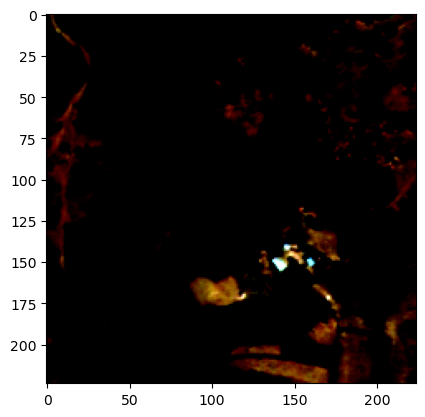

In [16]:
import matplotlib.pyplot as plt

plt.imshow(train_dataset[1999][0].permute(1, 2, 0))

# Train DyResnet

At this point, hopefully the model can be trained.

In [12]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
from torch.nn.parameter import Parameter
import torch
import torch.nn.functional as F
import torch.optim as optim

if accelerator.is_main_process:
    print("Loading Dymodel")

model_urls = {
    "resnet50": "https://download.pytorch.org/models/resnet50-19c8e357.pth",
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False
    )


class Hsigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(Hsigmoid, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return F.relu6(x + 3.0, inplace=self.inplace) / 3.0


class SEModule_small(nn.Module):
    def __init__(self, channel):
        super(SEModule_small, self).__init__()
        self.fc = nn.Sequential(nn.Linear(channel, channel, bias=False), Hsigmoid())

    def forward(self, x):
        y = self.fc(x)
        return x * y


class DYCls(nn.Module):
    def __init__(self, inp, oup):
        super(DYCls, self).__init__()
        self.dim = 32
        self.cls = nn.Linear(inp, oup)
        self.cls_q = nn.Linear(inp, self.dim, bias=False)
        self.cls_p = nn.Linear(self.dim, oup, bias=False)

        mid = 32

        self.fc = nn.Sequential(
            nn.Linear(inp, mid, bias=False),
            SEModule_small(mid),
        )
        self.fc_phi = nn.Linear(mid, self.dim**2, bias=False)
        self.fc_scale = nn.Linear(mid, oup, bias=False)
        self.hs = Hsigmoid()
        self.bn1 = nn.BatchNorm1d(self.dim)
        self.bn2 = nn.BatchNorm1d(self.dim)

    def forward(self, x):
        # r = self.cls(x)
        b, c = x.size()
        y = self.fc(x)
        dy_phi = self.fc_phi(y).view(b, self.dim, self.dim)
        dy_scale = self.hs(self.fc_scale(y)).view(b, -1)

        r = dy_scale * self.cls(x)

        x = self.cls_q(x)
        x = self.bn1(x)
        x = self.bn2(torch.matmul(dy_phi, x.view(b, self.dim, 1)).view(b, self.dim)) + x
        x = self.cls_p(x)

        return x + r


class conv_basic_dy(nn.Module):
    def __init__(self, inplanes, planes, stride):
        super(conv_basic_dy, self).__init__()

        self.conv = conv3x3(inplanes, planes, stride)
        self.dim = int(math.sqrt(inplanes * 4))
        squeeze = max(inplanes * 4, self.dim**2) // 16
        if squeeze < 4:
            squeeze = 4

        self.q = nn.Conv2d(inplanes, self.dim, 1, stride, 0, bias=False)

        self.p = nn.Conv2d(self.dim, planes, 1, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(self.dim)
        self.bn2 = nn.BatchNorm1d(self.dim)

        self.avg_pool = nn.AdaptiveAvgPool2d(2)

        self.fc = nn.Sequential(
            nn.Linear(inplanes * 4, squeeze, bias=False),
            SEModule_small(squeeze),
        )
        self.fc_phi = nn.Linear(squeeze, self.dim**2, bias=False)
        self.fc_scale = nn.Linear(squeeze, planes, bias=False)
        self.hs = Hsigmoid()

    def forward(self, x):
        r = self.conv(x)
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c * 4)
        y = self.fc(y)
        phi = self.fc_phi(y).view(b, self.dim, self.dim)
        scale = self.hs(self.fc_scale(y)).view(b, -1, 1, 1)
        r = scale.expand_as(r) * r

        out = self.bn1(self.q(x))
        _, _, h, w = out.size()

        out = out.view(b, self.dim, -1)
        out = self.bn2(torch.matmul(phi, out)) + out
        out = out.view(b, -1, h, w)
        out = self.p(out) + r

        return out


class BasicBlock_dy(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock_dy, self).__init__()

        self.inplanes = inplanes
        self.planes = planes
        self.conv1 = conv_basic_dy(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = conv_basic_dy(planes, planes, 1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        b, c, _, _ = x.size()
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class conv_dy(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, stride, padding):
        super(conv_dy, self).__init__()
        self.conv = nn.Conv2d(
            inplanes,
            planes,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=False,
        )
        self.dim = int(math.sqrt(inplanes))
        squeeze = max(inplanes, self.dim**2) // 16

        self.q = nn.Conv2d(inplanes, self.dim, 1, stride, 0, bias=False)

        self.p = nn.Conv2d(self.dim, planes, 1, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(self.dim)
        self.bn2 = nn.BatchNorm1d(self.dim)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Sequential(
            nn.Linear(inplanes, squeeze, bias=False),
            SEModule_small(squeeze),
        )
        self.fc_phi = nn.Linear(squeeze, self.dim**2, bias=False)
        self.fc_scale = nn.Linear(squeeze, planes, bias=False)
        self.hs = Hsigmoid()

    def forward(self, x):
        r = self.conv(x)
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y)
        phi = self.fc_phi(y).view(b, self.dim, self.dim)
        scale = self.hs(self.fc_scale(y)).view(b, -1, 1, 1)
        r = scale.expand_as(r) * r

        out = self.bn1(self.q(x))
        _, _, h, w = out.size()

        out = out.view(b, self.dim, -1)
        out = self.bn2(torch.matmul(phi, out)) + out
        out = out.view(b, -1, h, w)
        out = self.p(out) + r
        return out


class Bottleneck_dy(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck_dy, self).__init__()
        self.inplanes = inplanes
        self.planes = planes
        self.conv1 = conv_dy(inplanes, planes, 1, 1, 0)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv_dy(planes, planes, 3, stride, 1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv_dy(planes, planes * 4, 1, 1, 0)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet_dcd(nn.Module):
    def __init__(self, block, layers, num_classes=1, dropout=0.1):  #
        self.inplanes = 64
        super(ResNet_dcd, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        classifier = []
        if dropout is not None:
            classifier.append(nn.Dropout(p=dropout))
        classifier.append(DYCls(512 * block.expansion, num_classes))
        # classifier.append(nn.Linear(512 * block.expansion, num_classes))
        self.classifier = nn.Sequential(*classifier)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2.0 / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.inplanes,
                    planes * block.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x


def resnet50_dcd(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet_dcd(Bottleneck_dy, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls["resnet50"]))
    return model


net = resnet50_dcd(pretrained=False, num_classes=1)

Loading Dymodel


## Training

In [13]:
# specify the device for computation
#############################################
# your code here
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    print("Run on GPU...")
else:
    print("Run on CPU...")

# Model Definition
net = net.to(device)

Run on CPU...


In [16]:
import torch.nn as nn
import torch.optim as optim
import time

# initial learning rate
INITIAL_LR = 0.1

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

#############################################
# your code here
# create loss function
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()

# Add optimizer
# optimizer = optim.Adam(net.parameters(), lr=INITIAL_LR)
optimizer = optim.SGD(
    net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG
)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  ## from paper
#############################################

In [18]:
# Total number of training epochs
EPOCHS = 30

# The folder where the trained model is saved
CHECKPOINT_FOLDER = "harvestnet"

# Start the training/validation process
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("=" * 50)

for epoch in range(EPOCHS):
    start_time = time.time()

    net.train()
    running_loss = 0
    total_examples = 0
    correct_examples = 0

    for inputs, labels, _ in train_loader:
        inputs = inputs.float()  # Convert input data to torch.FloatTensor
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs > 0.5).float()
        correct = predicted.eq(labels).sum().item()
        correct_examples += correct
        total_examples += inputs.size(0)

    avg_loss = running_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print(
        f"Epoch {epoch+1}, Training Loss: {avg_loss:.4f}, Training Accuracy: {avg_acc:.4f}"
    )

    # Validation phase
    net.eval()
    val_loss = 0
    total_examples = 0
    correct_examples = 0

    with torch.no_grad():
        for inputs, targets, _ in test_loader:
            inputs = inputs.float()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)

            loss = criterion(outputs.squeeze(), targets.squeeze())
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            correct_examples += predicted.eq(targets).sum().item()
            total_examples += targets.size(0)

    avg_val_loss = val_loss / len(test_loader)
    avg_val_acc = correct_examples / total_examples
    print(
        f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}"
    )

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time
    print(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds")

    # Save the model checkpoint if it's the best so far
    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        print("Saving best model...")
        if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        state = {
            "state_dict": net.state_dict(),
            "epoch": epoch,
            "lr": current_learning_rate,
        }
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, "DyResnet_best.pth"))

    print("")

print("=" * 50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 1, Training Loss: 0.7404, Training Accuracy: 0.5513


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.5604
Epoch 1 completed in 1686.04 seconds
Saving best model...



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 2, Training Loss: 0.6833, Training Accuracy: 0.5402


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.5835
Epoch 2 completed in 1725.37 seconds
Saving best model...



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 3, Training Loss: 0.6762, Training Accuracy: 0.5538


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.5647
Epoch 3 completed in 1733.86 seconds



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 4, Training Loss: 0.6698, Training Accuracy: 0.5603


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.5640
Epoch 4 completed in 2552.28 seconds



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 5, Training Loss: 0.6596, Training Accuracy: 0.5679


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.5799
Epoch 5 completed in 1650.65 seconds



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 6, Training Loss: 0.6501, Training Accuracy: 0.5753


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.6356
Epoch 6 completed in 1675.45 seconds
Saving best model...



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 7, Training Loss: 0.6425, Training Accuracy: 0.6026


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.6276
Epoch 7 completed in 8606.49 seconds



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 8, Training Loss: 0.6558, Training Accuracy: 0.5724


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.5662
Epoch 8 completed in 2868.81 seconds



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 9, Training Loss: 0.6580, Training Accuracy: 0.5692


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.6247
Epoch 9 completed in 1590.87 seconds



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 10, Training Loss: 0.6557, Training Accuracy: 0.5809


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.6283
Epoch 10 completed in 1693.92 seconds



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 11, Training Loss: 0.6499, Training Accuracy: 0.5802


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.6067
Epoch 11 completed in 1691.63 seconds



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 12, Training Loss: 0.6466, Training Accuracy: 0.6051


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.6334
Epoch 12 completed in 1644.90 seconds



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 13, Training Loss: 0.6556, Training Accuracy: 0.5717


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.6312
Epoch 13 completed in 1603.54 seconds



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 14, Training Loss: 0.6407, Training Accuracy: 0.5890


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.6544
Epoch 14 completed in 1729.66 seconds
Saving best model...



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 15, Training Loss: 0.6333, Training Accuracy: 0.6171


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.5741
Epoch 15 completed in 1665.60 seconds



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 16, Training Loss: 0.6308, Training Accuracy: 0.6214


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.6255
Epoch 16 completed in 1658.35 seconds



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 17, Training Loss: 0.6329, Training Accuracy: 0.6272


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.6414
Epoch 17 completed in 1652.22 seconds



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 18, Training Loss: 0.6286, Training Accuracy: 0.6330


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.6703
Epoch 18 completed in 1662.45 seconds
Saving best model...



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 19, Training Loss: 0.6217, Training Accuracy: 0.6415


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.6544
Epoch 19 completed in 1619.16 seconds



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 20, Training Loss: 0.6153, Training Accuracy: 0.6480


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.6030
Epoch 20 completed in 1667.65 seconds



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 21, Training Loss: 0.6193, Training Accuracy: 0.6393


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.6479
Epoch 21 completed in 1706.23 seconds



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 22, Training Loss: 0.6065, Training Accuracy: 0.6583


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.5980
Epoch 22 completed in 1628.23 seconds



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 23, Training Loss: 0.6085, Training Accuracy: 0.6516


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.5799
Epoch 23 completed in 1606.56 seconds



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 24, Training Loss: 0.6000, Training Accuracy: 0.6614


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: 0.6197, Validation Accuracy: 0.6377
Epoch 24 completed in 1656.62 seconds



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 25, Training Loss: 0.5967, Training Accuracy: 0.6684


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.5893
Epoch 25 completed in 1635.94 seconds



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 26, Training Loss: 0.5951, Training Accuracy: 0.6648


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.6681
Epoch 26 completed in 9807.69 seconds



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 27, Training Loss: 0.5805, Training Accuracy: 0.6854


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.6710
Epoch 27 completed in 7063.49 seconds
Saving best model...



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 28, Training Loss: 0.5723, Training Accuracy: 0.6890


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.6797
Epoch 28 completed in 7057.85 seconds
Saving best model...



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 29, Training Loss: 0.5634, Training Accuracy: 0.6995


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.6725
Epoch 29 completed in 1650.61 seconds



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 30, Training Loss: 0.5471, Training Accuracy: 0.7044


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation Loss: nan, Validation Accuracy: 0.6956
Epoch 30 completed in 1647.26 seconds
Saving best model...

==> Optimization finished! Best validation accuracy: 0.6956


In [19]:
num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters in the trained model: {num_params}")

Number of parameters in the trained model: 27724169


below is original one !!!

In [50]:
# import torch.nn as nn
# import torch.optim as optim

# # hyperparameters, do NOT change right now
# # initial learning rate
# INITIAL_LR = 0.01

# # momentum for optimizer
# MOMENTUM = 0.9

# # L2 regularization strength
# REG = 1e-4

# #############################################
# # your code here
# # create loss function
# # criterion = nn.CrossEntropyLoss()
# criterion = nn.BCEWithLogitsLoss()

# # Add optimizer
# # optimizer = optim.Adam(net.parameters(), lr=INITIAL_LR)
# optimizer = optim.SGD(
#     net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG
# )
# #############################################

In [57]:
# # some hyperparameters
# # total number of training epochs
# EPOCHS = 50

# # the folder where the trained model is saved
# CHECKPOINT_FOLDER = "harvestnet"

# # start the training/validation process

# best_val_acc = 0
# current_learning_rate = INITIAL_LR

# print("==> Training starts!")
# print("=" * 50)
# for epoch in range(0, EPOCHS):
#     #######################

#     net.train()
#     running_loss = 0

#     for (
#         inputs,
#         labels,
#         filenames,
#     ) in train_loader:  # for inputs, labels in train_loader:
#         inputs = inputs.float()  # Convert input data to torch.FloatTensor
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = net(inputs)
#         print(outputs)
#         # loss = criterion(outputs, labels)
#         loss = criterion(outputs.squeeze(), labels.squeeze())
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#     #######################
#     print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader)}")
#     # print("Epoch %d:" %i)
#     # this help you compute the training accuracy
#     total_examples = 0
#     correct_examples = 0
#     train_loss = 0  # track training loss if you want

#     # Train the model for 1 epoch.
#     for batch_idx, (inputs, labels, filenames) in enumerate(train_loader):
#         ####################################
#         # your code here
#         # copy inputs to device
#         inputs = inputs.float()
#         inputs, labels = inputs.to(device), labels.to(device)

#         # compute the output and loss
#         outputs = net(inputs)

#         # zero the gradient
#         # loss = criterion(outputs, labels)
#         loss = criterion(outputs.squeeze(), labels.squeeze())
#         train_loss += loss.item()
#         optimizer.zero_grad()

#         # backpropagation
#         loss.backward()

#         # apply gradient and update the weights
#         optimizer.step()

#         # count the number of correctly predicted samples in the current batch
#         # _, predicted = outputs.max(1)
#         predicted = (outputs > 0.5).float()
#         correct = predicted.eq(labels).sum().item()
#         correct_examples += correct
#         total_examples += inputs.size(0)
#         ####################################

#     avg_loss = train_loss / len(train_loader)
#     avg_acc = correct_examples / total_examples
#     print("Training loss: %.4f, Training accuracy: %.4f" % (avg_loss, avg_acc))

#     # Validate on the validation dataset
#     #######################
#     # your code here
#     # switch to eval mode

#     #######################

#     # this help you compute the validation accuracy
#     total_examples = 0
#     correct_examples = 0

#     val_loss = 0  # again, track the validation loss if you want
#     net.eval()

#     # disable gradient during validation, which can save GPU memory
#     with torch.no_grad():
#         for batch_idx, (inputs, targets, filenames) in enumerate(test_loader):
#             ####################################
#             # your code here
#             # copy inputs to device
#             inputs = inputs.float()
#             inputs, targets = inputs.to(device), targets.to(device)
#             outputs = net(inputs)

#             # compute the output and loss
#             # loss = criterion(outputs, targets)
#             loss = criterion(outputs.squeeze(), targets.squeeze())
#             val_loss += loss.item()
#             # count the number of correctly predicted samples in the current batch

#             predicted = (outputs > 0.5).float()
#             total_examples += targets.size(0)
#             correct_examples += predicted.eq(targets).sum().item()
#             ####################################

#     avg_loss = val_loss / len(test_loader)
#     avg_acc = correct_examples / total_examples
#     print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

#     # save the model checkpoint
#     if avg_acc > best_val_acc:
#         best_val_acc = avg_acc
#         if not os.path.exists(CHECKPOINT_FOLDER):
#             os.makedirs(CHECKPOINT_FOLDER)
#         print("Saving ...")
#         state = {
#             "state_dict": net.state_dict(),
#             "epoch": epoch,
#             "lr": current_learning_rate,
#         }
#         torch.save(state, os.path.join(CHECKPOINT_FOLDER, "DyResnet_best.pth"))

#     print("")

# print("=" * 50)
# print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


tensor([[-0.3037],
        [ 0.3898],
        [-0.2838],
        [ 0.4469],
        [-0.4931],
        [ 0.2926],
        [-0.4078],
        [ 0.0995],
        [-2.0449],
        [-0.3368],
        [-0.5754],
        [ 0.3818],
        [-0.4650],
        [-0.0302],
        [ 0.3093],
        [-0.5116],
        [-0.4193],
        [ 0.3253],
        [ 0.1099],
        [ 0.4802],
        [-0.4734],
        [-0.1316],
        [-0.6509],
        [-0.4703],
        [-0.4779],
        [ 0.0907],
        [ 0.1530],
        [ 0.3163],
        [-0.4664],
        [-0.4281],
        [ 0.3427],
        [-0.0452]], grad_fn=<AddBackward0>)
tensor([[ 0.4508],
        [ 0.5297],
        [ 0.2677],
        [-0.2688],
        [ 0.5451],
        [-0.6154],
        [ 0.1614],
        [-0.0756],
        [ 0.0577],
        [-0.2128],
        [-0.2380],
        [-0.4528],
        [ 0.1714],
        [-0.6579],
        [-0.5537],
        [ 0.0794],
        [-0.5834],
        [-0.4696],
        [ 0.3853],
      

/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Training loss: 0.6631, Training accuracy: 0.5838


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation loss: nan, Validation accuracy: 0.6269
Saving ...



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


tensor([[ 0.6395],
        [-0.3448],
        [ 0.6376],
        [ 0.5200],
        [ 0.4286],
        [ 0.9079],
        [-0.4836],
        [-0.3723],
        [-0.5691],
        [ 0.8582],
        [ 0.5915],
        [-0.0715],
        [ 0.8557],
        [-0.9802],
        [-0.7749],
        [-1.5597],
        [-1.2238],
        [-0.2441],
        [-0.7461],
        [ 0.8771],
        [ 0.2340],
        [-0.8167],
        [-0.0516],
        [ 0.3124],
        [-0.1084],
        [-1.5996],
        [-0.4789],
        [ 0.8899],
        [ 0.4963],
        [-0.3958],
        [ 0.7481],
        [-3.9848]], grad_fn=<AddBackward0>)
tensor([[ 0.6390],
        [-0.4964],
        [ 0.1791],
        [ 0.6547],
        [ 0.4788],
        [ 0.5961],
        [-0.0464],
        [ 0.4492],
        [ 0.6136],
        [-1.7352],
        [-3.3916],
        [ 0.8564],
        [-0.4047],
        [-0.3494],
        [ 0.7388],
        [-0.5583],
        [-0.1065],
        [-0.9360],
        [-1.2058],
      

/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Training loss: 0.6544, Training accuracy: 0.5937


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation loss: nan, Validation accuracy: 0.6283
Saving ...



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


tensor([[-1.4022],
        [ 0.8504],
        [-0.1788],
        [-0.5614],
        [ 0.8087],
        [-0.4994],
        [ 0.6026],
        [-1.6078],
        [ 0.7784],
        [-0.8881],
        [-0.2804],
        [-2.1986],
        [-0.6498],
        [ 0.6909],
        [ 0.6394],
        [ 0.0989],
        [-0.1431],
        [ 0.2025],
        [ 0.8074],
        [-2.0199],
        [ 0.0983],
        [-1.1298],
        [-0.2224],
        [ 0.5984],
        [ 0.2988],
        [-0.0905],
        [ 0.7785],
        [-0.1993],
        [ 0.2651],
        [ 0.3392],
        [-1.6439],
        [-1.3563]], grad_fn=<AddBackward0>)
tensor([[-2.3157],
        [ 0.2358],
        [-1.2823],
        [ 0.3480],
        [ 0.2671],
        [ 0.1237],
        [-1.4036],
        [ 0.4007],
        [-0.4538],
        [-1.0725],
        [-1.1963],
        [ 0.4790],
        [ 0.7780],
        [-0.4142],
        [ 0.4540],
        [ 0.5154],
        [ 0.5959],
        [ 0.3104],
        [-0.0234],
      

/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Training loss: 0.6557, Training accuracy: 0.6057


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation loss: nan, Validation accuracy: 0.6088



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


tensor([[-0.4000],
        [-0.5928],
        [-0.5454],
        [ 0.2171],
        [ 0.0138],
        [ 0.1135],
        [ 0.4964],
        [-0.7528],
        [-0.6787],
        [-0.0266],
        [-0.8062],
        [-0.2597],
        [ 0.4951],
        [-0.6891],
        [ 0.8289],
        [-0.1560],
        [ 0.5233],
        [-0.5052],
        [-0.9335],
        [-0.4268],
        [-1.2972],
        [ 0.0037],
        [-0.7283],
        [ 0.2851],
        [ 0.5562],
        [-0.7030],
        [ 0.4821],
        [ 0.6789],
        [-1.0622],
        [ 0.0692],
        [-0.2801],
        [-0.7164]], grad_fn=<AddBackward0>)
tensor([[ 0.0836],
        [-0.8249],
        [-0.7397],
        [-0.8803],
        [ 0.1776],
        [ 0.6196],
        [-0.1790],
        [-0.2120],
        [-0.5025],
        [-0.1241],
        [-1.0622],
        [ 0.6101],
        [ 0.4056],
        [ 0.5186],
        [ 0.2724],
        [-0.8279],
        [-0.4936],
        [ 0.1131],
        [-1.0697],
      

/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Training loss: 0.6419, Training accuracy: 0.5999


/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Validation loss: nan, Validation accuracy: 0.6117



/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


tensor([[-5.0285e-01],
        [ 2.2540e-01],
        [-3.6146e+00],
        [-3.7497e-01],
        [ 6.0122e-01],
        [-4.1729e-01],
        [-3.8806e-01],
        [ 6.8369e-02],
        [ 5.4031e-01],
        [ 6.6102e-01],
        [ 4.4425e-01],
        [-1.2893e+00],
        [ 3.6438e-01],
        [-4.1396e-01],
        [ 5.3127e-01],
        [-1.6515e-01],
        [-7.0408e-01],
        [ 4.7590e-01],
        [ 6.3131e-01],
        [ 9.8984e-02],
        [ 5.9530e-01],
        [-1.3754e+00],
        [ 3.0160e-01],
        [ 5.1504e-01],
        [-1.8379e-01],
        [-1.5539e+00],
        [-7.0980e-01],
        [-1.2541e+00],
        [-4.7148e-01],
        [-7.5679e-04],
        [-7.6291e-02],
        [ 4.7006e-01]], grad_fn=<AddBackward0>)
tensor([[ 0.4279],
        [ 0.5961],
        [-0.1686],
        [ 0.0706],
        [-1.1152],
        [ 0.1810],
        [-0.6530],
        [-0.0907],
        [ 0.5491],
        [-0.2154],
        [ 0.3483],
        [-0.3524],
        [-0

/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/meixiangdu/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


KeyboardInterrupt: 

## plots for the report 

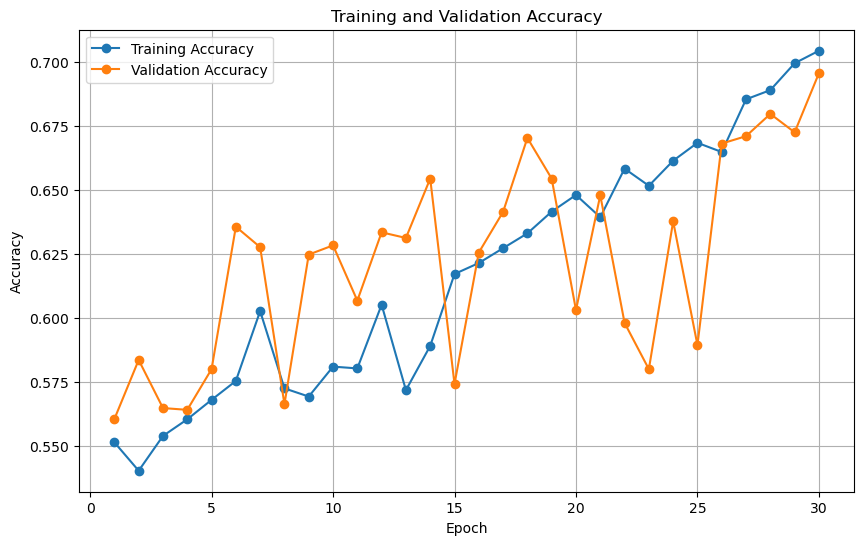

In [20]:
# accurcy from original paper params
import matplotlib.pyplot as plt

# Training and validation accuracy values
training_accuracy = [
    0.5513,
    0.5402,
    0.5538,
    0.5603,
    0.5679,
    0.5753,
    0.6026,
    0.5724,
    0.5692,
    0.5809,
    0.5802,
    0.6051,
    0.5717,
    0.5890,
    0.6171,
    0.6214,
    0.6272,
    0.6330,
    0.6415,
    0.6480,
    0.6393,
    0.6583,
    0.6516,
    0.6614,
    0.6684,
    0.6648,
    0.6854,
    0.6890,
    0.6995,
    0.7044,
]
validation_accuracy = [
    0.5604,
    0.5835,
    0.5647,
    0.5640,
    0.5799,
    0.6356,
    0.6276,
    0.5662,
    0.6247,
    0.6283,
    0.6067,
    0.6334,
    0.6312,
    0.6544,
    0.5741,
    0.6255,
    0.6414,
    0.6703,
    0.6544,
    0.6030,
    0.6479,
    0.5980,
    0.5799,
    0.6377,
    0.5893,
    0.6681,
    0.6710,
    0.6797,
    0.6725,
    0.6956,
]

# Create a list of epoch numbers
epochs = list(range(1, len(training_accuracy) + 1))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracy, label="Training Accuracy", marker="o")
plt.plot(epochs, validation_accuracy, label="Validation Accuracy", marker="o")
plt.title("DyResnet50 Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

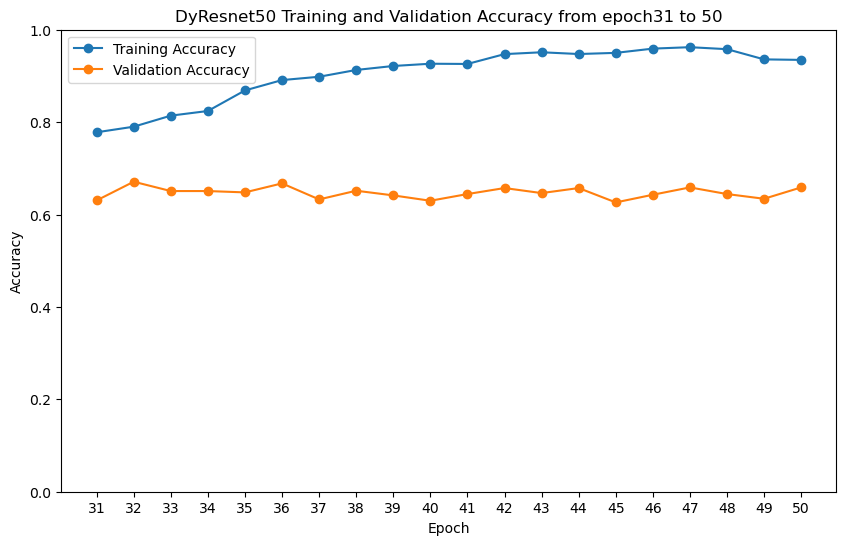

In [61]:
# accurcy from training based on best performance model , with params
# Optimizer: SGD
# INITIAL_LR: 0.01
# MOMENTUM: 0.9
# REG l2= 1e-4#

import matplotlib.pyplot as plt

# Training and validation accuracy values
training_accuracy = [
    0.7780,
    0.7901,
    0.8140,
    0.8241,
    0.8686,
    0.8910,
    0.8982,
    0.9129,
    0.9215,
    0.9264,
    0.9259,
    0.9472,
    0.9512,
    0.9474,
    0.9499,
    0.9591,
    0.9622,
    0.9579,
    0.9358,
    0.9347,
]
validation_accuracy = [
    0.6305,
    0.6710,
    0.6508,
    0.6508,
    0.6479,
    0.6674,
    0.6327,
    0.6515,
    0.6414,
    0.6298,
    0.6443,
    0.6573,
    0.6464,
    0.6573,
    0.6262,
    0.6428,
    0.6587,
    0.6443,
    0.6341,
    0.6587,
]

# Create a list of epoch numbers
epochs = list(range(31, 51))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracy, label="Training Accuracy", marker="o")
plt.plot(epochs, validation_accuracy, label="Validation Accuracy", marker="o")
plt.title("DyResnet50 Training and Validation Accuracy from epoch31 to 50")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(epochs[::1])
plt.ylim(0, 1)

plt.show()

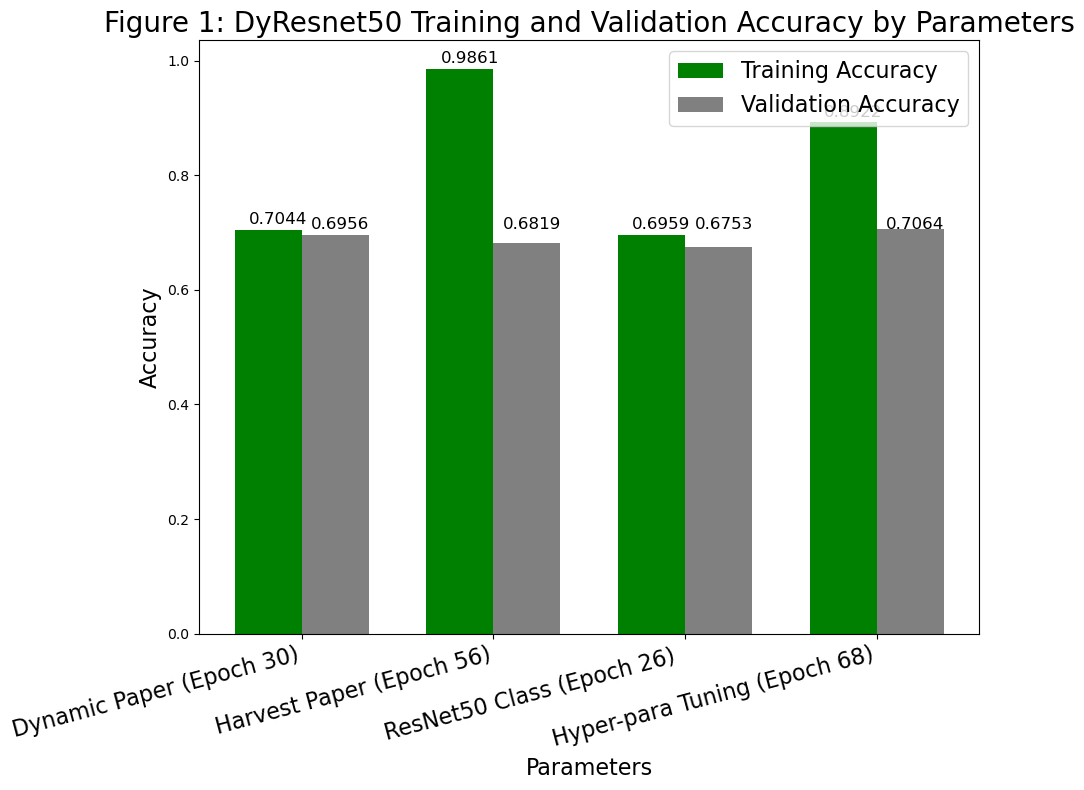

In [39]:
# best accuracy for four sets of params with coresponding accurcy
# Dynamic Paper adjsut step size from 30 to 10
# INITIAL_LR = 0.1
# MOMENTUM = 0.9
# REG = 1e-4

# criterion = nn.BCEWithLogitsLoss()

# optimizer = optim.SGD(
#     net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG
# )
# scheduler = optim.lr_scheduler.StepLR(
#     optimizer, step_size=10, gamma=0.1
# )

# Harvest paper
# INITIAL_LR  = 1e-3  # Learning rate
# MOMENTUM = 0.9  # Momentum for SGD optimizer
# WEIGHT_DECAY = 1e-4  # Weight decay for L2 regularization due to overfitting
# EPOCHS = 100  # Total number of training epochs

# # Loss function
# criterion = nn.BCEWithLogitsLoss()

# # Optimizer (Adam with default parameters)
# optimizer = optim.Adam(net.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)

# # Learning rate scheduler (One Cycle scheduler)
# scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=INITIAL_LR, total_steps=EPOCHS)

# hyper to address over fitting

# INITIAL_LR  = 1e-2  # Learning rate
# MOMENTUM = 0.9  # Momentum for SGD optimizer
# WEIGHT_DECAY = 1e-3  # Weight decay for L2 regularization due to overfitting
# EPOCHS = 100  # Total number of training epochs


import matplotlib.pyplot as plt

# Data
params = [
    "Dynamic Paper (Epoch 30)",
    "Harvest Paper (Epoch 56)",
    "ResNet50 Class (Epoch 26) ",
    "Hyper-para Tuning (Epoch 68)",
]
train_accuracy = [0.7044, 0.9861, 0.6959, 0.8922]
validation_accuracy = [0.6956, 0.6819, 0.6753, 0.7064]

# Number of groups
num_params = len(params)

# Width of each bar
bar_width = 0.35

# Index of each group
index = range(num_params)

# Plotting
plt.figure(figsize=(10, 8))
train_bars = plt.bar(
    index, train_accuracy, bar_width, label="Training Accuracy", color="g"
)
val_bars = plt.bar(
    [i + bar_width for i in index],
    validation_accuracy,
    bar_width,
    label="Validation Accuracy",
    color="gray",
)

# Add labels, title, and legend
plt.xlabel("Parameters", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.title(
    "Figure 1: DyResnet50 Training and Validation Accuracy by Parameters", fontsize=20
)
plt.xticks(
    [i + bar_width / 2 for i in index], params, rotation=15, ha="right", fontsize=16
)
plt.legend(fontsize=16)

# Add text labels on top of each bar
for bar, train_acc, val_acc in zip(train_bars, train_accuracy, validation_accuracy):
    plt.text(
        bar.get_x() + bar.get_width() / 2 - 0.1,
        bar.get_height() + 0.01,
        f"{train_acc:.4f}",
        fontsize=12,
        color="black",
    )
    plt.text(
        bar.get_x() + bar.get_width() + 0.05,
        val_bars[0].get_height() + 0.01,
        f"{val_acc:.4f}",
        fontsize=12,
        color="black",
    )

# Show plot
plt.tight_layout()
plt.show()

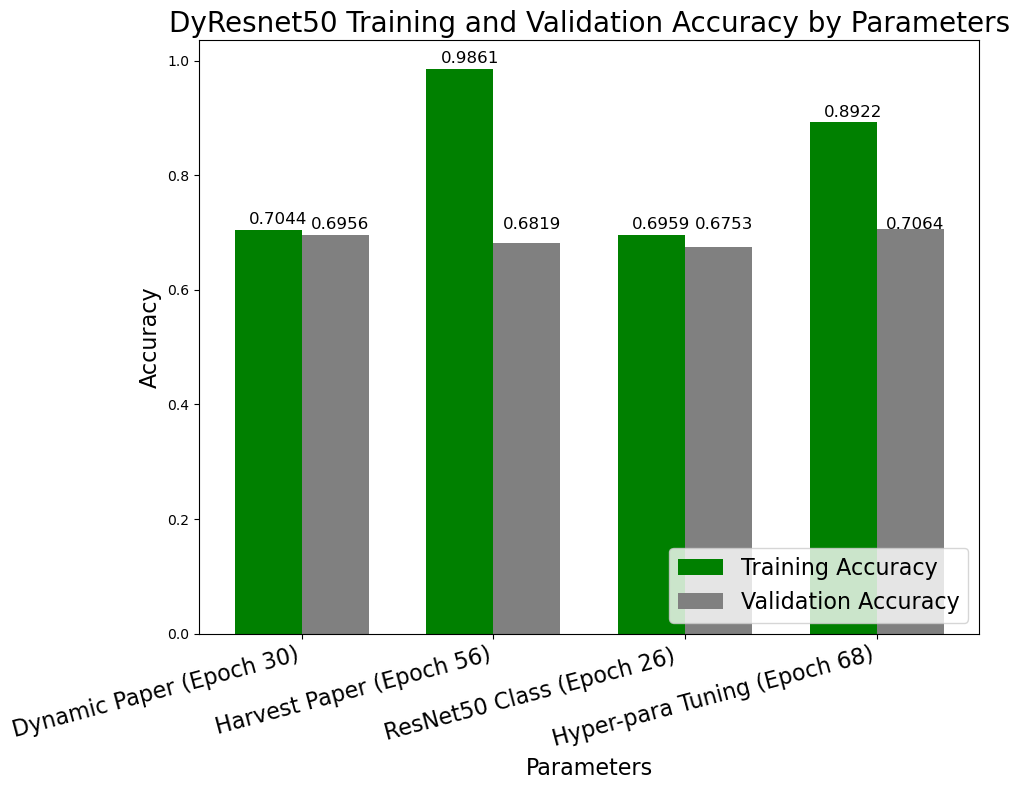

In [41]:
import matplotlib.pyplot as plt

# Data
params = [
    "Dynamic Paper (Epoch 30)",
    "Harvest Paper (Epoch 56)",
    "ResNet50 Class (Epoch 26) ",
    "Hyper-para Tuning (Epoch 68)",
]
train_accuracy = [0.7044, 0.9861, 0.6959, 0.8922]
validation_accuracy = [0.6956, 0.6819, 0.6753, 0.7064]

# Number of groups
num_params = len(params)

# Width of each bar
bar_width = 0.35

# Index of each group
index = range(num_params)

# Plotting
plt.figure(figsize=(10, 8))
train_bars = plt.bar(
    index, train_accuracy, bar_width, label="Training Accuracy", color="g"
)
val_bars = plt.bar(
    [i + bar_width for i in index],
    validation_accuracy,
    bar_width,
    label="Validation Accuracy",
    color="gray",
)

# Add labels, title, and legend
plt.xlabel("Parameters", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.title("DyResnet50 Training and Validation Accuracy by Parameters", fontsize=20)
plt.xticks(
    [i + bar_width / 2 for i in index], params, rotation=15, ha="right", fontsize=16
)
plt.legend(fontsize=16, loc="lower right")

# Add text labels on top of each bar
for bar, train_acc, val_acc in zip(train_bars, train_accuracy, validation_accuracy):
    plt.text(
        bar.get_x() + bar.get_width() / 2 - 0.1,
        bar.get_height() + 0.01,
        f"{train_acc:.4f}",
        fontsize=12,
        color="black",
    )
    plt.text(
        bar.get_x() + bar.get_width() + 0.05,
        val_bars[0].get_height() + 0.01,
        f"{val_acc:.4f}",
        fontsize=12,
        color="black",
    )

# Show plot
plt.tight_layout()
plt.show()